__Forecasting__

- Build sequences (input windows).
- Train baselines (naive, EWMA).
- Train LSTM/GRU
- Stability: Try walk‑forward validation to ensure the improvement holds across different time periods/regimes.???
- Explore PCA in choosing key features
- Explore with and without unsupervised learning approach

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import layers, models
from pycaret.regression import setup, compare_models, pull

2025-10-05 17:48:57.712540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


__Load parquet with aggregated features and regimes__

In [2]:
spy_df = pd.read_parquet("daily_spy_features_with_regimes.parquet") 
spy_df.sample(3)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime
58,2023-04-20,SPY,0.159266,0.077128,0.014312,0.127854,0.034421,58.018087,-22.502624,-0.226108,...,-1.677645,-2.085412,-1.899827,-0.991941,1.369051,4.438584,9.880932,16.248005,2023,0.0
243,2023-06-08,SPY,0.147800,0.031760,-0.013345,0.176124,0.143179,53.816864,-20.992304,0.253751,...,1.830154,2.039324,2.112921,3.823741,7.410085,12.335435,15.708492,18.988026,2023,2.0
4,2023-02-01,SPY,0.164627,0.047374,0.006307,0.053491,0.200831,62.584067,-31.497720,0.315165,...,2.807362,4.701992,7.814799,7.241065,7.232569,11.577576,15.007001,26.482473,2023,2.0


In [3]:
qqq_df = pd.read_parquet("daily_qqq_features_with_regimes.parquet") 
qqq_df.sample(3)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime
30,2023-03-21,QQQ,0.237290,0.060785,0.003858,0.079406,0.124364,46.692307,-30.026806,0.556496,...,3.848380,4.707265,6.285323,12.219021,17.193499,13.792734,12.351726,14.004739,2023,2.0
17,2023-03-02,QQQ,0.236440,0.037123,0.016192,0.070081,0.049806,43.148818,-29.656593,0.282300,...,1.636581,1.066077,0.010461,-0.177843,-3.790798,-11.440340,-9.647253,10.288094,2023,0.0
168,2023-03-13,QQQ,0.248967,0.108501,0.033971,0.123411,0.048938,45.516087,-33.457121,0.253470,...,0.917228,-0.943765,-4.581189,-6.637115,-5.025310,-5.662701,-12.111594,-1.006147,2023,1.0


In [4]:
def load_merged_tbills(start_year, end_year):
    """Load and merge data for multiple tickers across a range of years."""
    all_data = []

    for year in range(start_year, end_year + 1):
        try:
            df = pd.read_parquet(f"tbills/year={year}", engine="pyarrow")
            all_data.append(df)
        except FileNotFoundError:
            print(f"Data not found for {year}, skipping.")
        except Exception as e:
            print(f"Error loading {year}: {e}")

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()

In [5]:
t_bills_df = load_merged_tbills(2023, 2023)

In [6]:
spy_df = spy_df.merge(t_bills_df[['date','treasury_2y']], on='date', how='left')
spy_df.sample(3)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime,treasury_2y
215,2023-04-28,SPY,0.158634,0.046284,-0.022077,0.105879,0.076522,62.627774,-18.647879,0.405535,...,6.180646,8.447782,6.831182,3.532637,4.702187,9.209826,15.458093,2023,2.0,4.04
131,2023-08-04,SPY,0.159422,0.072452,-0.003023,0.123344,0.089057,62.136542,-19.549252,-0.246081,...,-3.102228,-5.617249,-7.998922,-7.898558,-4.751947,1.150313,11.465423,2023,1.0,4.78
164,2023-02-14,SPY,0.182586,0.060345,-0.002272,0.146752,0.123991,58.963319,-28.938284,-0.010509,...,1.011665,3.487878,3.901360,0.635005,1.877913,10.770690,20.196328,2023,0.0,4.6


In [7]:
qqq_df = qqq_df.merge(t_bills_df[['date','treasury_2y']], on='date', how='left')
qqq_df.sample(3)

,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime,treasury_2y
110,2023-07-17,QQQ,0.182607,0.047351,0.004834,0.106721,0.205900,46.850990,-19.816265,0.521840,...,5.339275,8.711533,14.246619,16.331145,18.572479,25.924131,44.371907,2023,2.0,4.74
153,2023-02-17,QQQ,0.232914,0.071386,0.004417,0.041456,0.164915,46.436514,-27.192597,-0.237078,...,-4.586832,-6.758867,-2.908692,-1.995848,-3.448528,10.483538,27.387651,2023,1.0,4.6
202,2023-05-01,QQQ,0.182541,0.066690,0.030313,0.077776,0.114579,46.330634,-23.246692,-0.002638,...,2.734385,6.494249,8.368595,4.936805,5.618948,9.971335,21.174205,2023,0.0,4.14


In [8]:
def trim_price_diffs(df):
    # Define the ones you want to keep
    keep_diffs = ['price_diff_1d', 'price_diff_8d', 'price_diff_13d', 'price_diff_21d']

    # Identify all price_diff columns
    all_diffs = [col for col in df.columns if col.startswith('price_diff_')]

    # Drop the ones not in the keep list
    drop_diffs = [col for col in all_diffs if col not in keep_diffs]
    df = df.drop(columns=drop_diffs)
    return df

In [9]:
def feature_extraction(df, tbills=False, regime=False, W=180, H=30):
    df = trim_price_diffs(df)
    display(df.sample(5))
    
    # Preserve original ATM_IV for target scaling
    df['ATM_IV_orig'] = df['ATM_IV']
    
    feature_scaler_cols = [
        'ATM_IV', 'Skew', 'Curvature', 'IV_std',
        'Avg_Delta', 'Avg_Vega', 'Avg_Theta',
        'price_diff_1d', 'price_diff_8d', 'price_diff_13d', 'price_diff_21d'
    ]
    
    if tbills:
        feature_scaler_cols += ['treasury_2y']
    
    # 1. Feature scaler
    feature_scaler = StandardScaler()
    df[feature_scaler_cols] = feature_scaler.fit_transform(df[feature_scaler_cols])
    
    # 2. Target scaler (ATM_IV only)
    target_scaler = StandardScaler()
    df['ATM_IV_target'] = target_scaler.fit_transform(
        df[['ATM_IV_orig']]
    )

    if regime:
        df = pd.get_dummies(df, columns=['regime'], prefix='regime')
        regime_cols = [col for col in df.columns if col.startswith('regime_')]
        df[regime_cols] = df[regime_cols].astype(int)
    else:
        df = df.drop('regime', axis=1)

    feature_cols = feature_scaler_cols
    if regime:
        feature_cols += [c for c in df.columns if c.startswith('regime_')]

    # Build rollwing window size of W and target ATM_IV for next H days
    XH, yH, metaH = build_sequences(df, feature_cols, 'ATM_IV_target', W, H)
    print(XH.shape, yH.shape) 
    
    return (XH, yH, metaH)

In [10]:
def build_sequences(df, feature_cols, target_col='ATM_IV_target', W=60, H=3):
    """
    Build rolling input/output sequences for multi-step forecasting.
    
    Args:
        df : DataFrame with features and target
        feature_cols : list of feature column names
        target_col : str, column to forecast
        W : int, input window length
        H : int, forecast horizon (number of steps ahead)
    
    Returns:
        X : np.array, shape (N, W, F)
        y : np.array, shape (N, H)
        meta : pd.DataFrame, metadata with ticker and end_date
    """
    Xs, ys, meta = [], [], []
    
    for ticker, g in df.groupby('ticker'):
        g = g.sort_values('date').reset_index(drop=True)
        X_mat = g[feature_cols].values
        y_mat = g[target_col].values
        dates = g['date'].values
        
        for i in range(W-1, len(g)-H):
            x_win = X_mat[i-W+1:i+1]          # shape (W, F)
            y_target = y_mat[i+1:i+H+1]       # shape (H,)
            
            if np.isnan(y_target).any() or np.isnan(x_win).any():
                continue
            
            Xs.append(x_win)
            ys.append(y_target)
            meta.append({'ticker': ticker, 'end_date': dates[i]})
    
    X = np.array(Xs)
    y = np.array(ys)
    meta = pd.DataFrame(meta)
    return X, y, meta


In [11]:
def ewma_forecast(X, alpha=0.3):
    """
    EWMA baseline: forecast a single value from past ATM_IV values.
    """
    preds = []
    for x in X:
        iv_series = x[:, 0]  # ATM_IV is first feature
        ewma_val = iv_series[0]
        for val in iv_series[1:]:
            ewma_val = alpha * val + (1 - alpha) * ewma_val
        preds.append(ewma_val)
        
    return np.array(preds)

In [12]:
def baseline_models_forecast(xH, yH, metaH, useMean=False):
    # Flatten XH (N, W, F) → (N, W×F)
    X_flat = XH.reshape(XH.shape[0], -1)

    # Flatten yH (N, H) → use mean or first step as target
    y_flat = np.mean(yH, axis=1) if useMean else yH[:, 0]

    # Combine into a DataFrame
    pycaret_df = pd.DataFrame(X_flat)
    pycaret_df['target'] = y_flat
    
    # Initialize PyCaret
    regression_setup = setup(
        data=pycaret_df,
        target='target',
        session_id=42,
        normalize=False,
        preprocess=False
    )

    # Compare models
    best_models = compare_models(n_select=5)
    results_df = pull()
    
    # EWMA forecast
    ewma_preds = ewma_forecast(XH)
    ewma_mse = mean_squared_error(y_flat, ewma_preds)
    ewma_mae = mean_absolute_error(y_flat, ewma_preds)

    results_df.loc[len(results_df)] = ['EWMA', ewma_mse, ewma_mae, None, None, None, None, None]
    
    print("Baseline model results")
    print("===================================================")
    display(results_df)
    
    return results_df
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(data=results_df, x='Model', y='MAE')
#     plt.title('Model Comparison by MAE')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

In [13]:
W_list = [180, 240]
H = 30
useMean_flags = [True]
tbills_flags = [False]
regime_flags = [False]
dfs = {'SPY': spy_df, 'QQQ': qqq_df}

all_results = []

for name, df in dfs.items():
    for useMean in useMean_flags:
        for tbills in tbills_flags:
            for regime in regime_flags:
                for W in W_list:
                    print(f"\nRunning {name} | W={W}, H={H}, tbills={tbills}, regime={regime}, useMean={useMean}")
                    
                    # Step 1: Load and preprocess
                    XH, yH, metaH = feature_extraction(df, tbills=tbills, regime=regime, W=W, H=H)

                    # Step 2: Run baseline models
                    result_df = baseline_models_forecast(XH, yH, metaH, useMean=useMean)

                    # Step 3: Annotate results
                    result_df['W'] = W
                    result_df['H'] = H
                    result_df['tbills'] = tbills
                    result_df['regime'] = regime
                    result_df['useMean'] = useMean
                    result_df['ticker'] = name  
                        
                    all_results.append(result_df)


Running SPY | W=180, H=30, tbills=False, regime=False, useMean=True


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,price_diff_8d,price_diff_13d,price_diff_21d,year,regime,treasury_2y
227,2023-05-16,SPY,0.162861,0.091045,0.016567,0.207383,0.086807,54.041659,-23.200726,-0.271806,-1.946516,-2.085148,-1.732532,2023,1.0,4.06
211,2023-04-24,SPY,0.178380,0.072307,-0.020759,0.113650,0.039060,58.302480,-19.412519,0.040249,0.288217,0.315695,-0.086899,2023,0.0,4.12
70,2023-05-08,SPY,0.164477,0.087082,0.001940,0.113502,0.037393,56.615630,-20.889603,0.063358,0.814026,2.620332,4.549836,2023,0.0,4.0
292,2023-08-18,SPY,0.155869,0.090884,0.017217,0.112806,0.027779,61.114609,-17.112062,-0.038334,-0.541918,-1.915242,-4.881395,2023,1.0,4.92
45,2023-03-31,SPY,0.179259,0.068097,-0.000667,0.102485,0.140814,65.728481,-22.302712,0.565150,4.428520,6.617660,9.488044,2023,2.0,4.06


(93, 180, 11) (93, 30)


,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(93, 1981)"
4,Transformed data shape,"(93, 1981)"
5,Transformed train set shape,"(65, 1981)"
6,Transformed test set shape,"(28, 1981)"
7,Numeric features,1980


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0348,0.0020,0.0427,0.9603,0.0238,0.0470,0.1910
lr,Linear Regression,0.0347,0.0020,0.0427,0.9602,0.0238,0.0470,1.0150
ridge,Ridge Regression,0.0348,0.0020,0.0427,0.9602,0.0238,0.0471,0.2130
ada,AdaBoost Regressor,0.0379,0.0027,0.0494,0.9346,0.0274,0.0500,0.9580
huber,Huber Regressor,0.0519,0.0046,0.0632,0.9001,0.0337,0.0598,0.2280
et,Extra Trees Regressor,0.0550,0.0055,0.0727,0.8754,0.0397,0.0715,1.3110
lightgbm,Light Gradient Boosting Machine,0.0587,0.0055,0.0709,0.8624,0.0398,0.0785,0.4060
gbr,Gradient Boosting Regressor,0.0579,0.0077,0.0808,0.8084,0.0452,0.0774,1.9910
rf,Random Forest Regressor,0.0789,0.0111,0.1008,0.7747,0.0563,0.1091,1.2680
par,Passive Aggressive Regressor,0.0900,0.0110,0.1024,0.7574,0.0554,0.1066,0.1540


Baseline model results


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.03480,0.002000,0.0427,0.9603,0.0238,0.0470,0.191
lr,Linear Regression,0.03470,0.002000,0.0427,0.9602,0.0238,0.0470,1.015
ridge,Ridge Regression,0.03480,0.002000,0.0427,0.9602,0.0238,0.0471,0.213
ada,AdaBoost Regressor,0.03790,0.002700,0.0494,0.9346,0.0274,0.0500,0.958
huber,Huber Regressor,0.05190,0.004600,0.0632,0.9001,0.0337,0.0598,0.228
et,Extra Trees Regressor,0.05500,0.005500,0.0727,0.8754,0.0397,0.0715,1.311
lightgbm,Light Gradient Boosting Machine,0.05870,0.005500,0.0709,0.8624,0.0398,0.0785,0.406
gbr,Gradient Boosting Regressor,0.05790,0.007700,0.0808,0.8084,0.0452,0.0774,1.991
rf,Random Forest Regressor,0.07890,0.011100,0.1008,0.7747,0.0563,0.1091,1.268
par,Passive Aggressive Regressor,0.09000,0.011000,0.1024,0.7574,0.0554,0.1066,0.154



Running SPY | W=240, H=30, tbills=False, regime=False, useMean=True


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,price_diff_8d,price_diff_13d,price_diff_21d,year,regime,treasury_2y
179,2023-03-08,SPY,0.184364,0.064269,0.000023,0.102159,0.020356,51.995997,-24.187362,0.037138,-0.039778,-1.546458,-3.733983,2023,0.0,5.05
228,2023-05-17,SPY,0.162616,0.066364,0.011139,0.140860,0.045886,55.684223,-19.222896,0.472608,3.403142,3.721490,3.203460,2023,2.0,4.12
111,2023-07-07,SPY,0.145302,0.079926,0.014629,0.113467,0.113856,60.140284,-17.220989,-0.138217,-1.206381,-2.371281,-3.520065,2023,0.0,4.94
246,2023-06-13,SPY,0.140719,0.046782,-0.003841,0.150393,0.135141,58.297440,-16.819297,0.349709,2.852973,4.751621,6.942621,2023,2.0,4.67
60,2023-04-24,SPY,0.178380,0.072307,-0.020759,0.112136,0.039060,58.302480,-19.412519,0.040249,0.288217,0.315695,-0.086899,2023,0.0,4.12


(33, 240, 11) (33, 30)


,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(33, 2641)"
4,Transformed data shape,"(33, 2641)"
5,Transformed train set shape,"(23, 2641)"
6,Transformed test set shape,"(10, 2641)"
7,Numeric features,2640


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0398,0.0029,0.0448,0.3050,0.0275,0.0654,0.1360
br,Bayesian Ridge,0.0403,0.0029,0.0451,0.2777,0.0277,0.0665,0.2050
ridge,Ridge Regression,0.0403,0.0029,0.0451,0.2771,0.0277,0.0665,0.1340
gbr,Gradient Boosting Regressor,0.0630,0.0076,0.0741,-0.4634,0.0458,0.1045,0.6180
et,Extra Trees Regressor,0.0598,0.0065,0.0717,-0.4926,0.0443,0.1010,0.5260
rf,Random Forest Regressor,0.0636,0.0064,0.0731,-0.8296,0.0451,0.1066,0.5210
ada,AdaBoost Regressor,0.0435,0.0055,0.0527,-1.2022,0.0321,0.0673,0.3090
knn,K Neighbors Regressor,0.0561,0.0050,0.0628,-1.9040,0.0390,0.0981,0.1540
huber,Huber Regressor,0.0695,0.0108,0.0820,-2.3074,0.0508,0.1031,0.1890
par,Passive Aggressive Regressor,0.0987,0.0170,0.1150,-5.2120,0.0724,0.1505,0.1700


Baseline model results


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.039800,2.900000e-03,0.0448,3.050000e-01,0.0275,0.0654,0.136
br,Bayesian Ridge,0.040300,2.900000e-03,0.0451,2.777000e-01,0.0277,0.0665,0.205
ridge,Ridge Regression,0.040300,2.900000e-03,0.0451,2.771000e-01,0.0277,0.0665,0.134
gbr,Gradient Boosting Regressor,0.063000,7.600000e-03,0.0741,-4.634000e-01,0.0458,0.1045,0.618
et,Extra Trees Regressor,0.059800,6.500000e-03,0.0717,-4.926000e-01,0.0443,0.1010,0.526
rf,Random Forest Regressor,0.063600,6.400000e-03,0.0731,-8.296000e-01,0.0451,0.1066,0.521
ada,AdaBoost Regressor,0.043500,5.500000e-03,0.0527,-1.202200e+00,0.0321,0.0673,0.309
knn,K Neighbors Regressor,0.056100,5.000000e-03,0.0628,-1.904000e+00,0.0390,0.0981,0.154
huber,Huber Regressor,0.069500,1.080000e-02,0.0820,-2.307400e+00,0.0508,0.1031,0.189
par,Passive Aggressive Regressor,0.098700,1.700000e-02,0.1150,-5.212000e+00,0.0724,0.1505,0.170



Running QQQ | W=180, H=30, tbills=False, regime=False, useMean=True


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,price_diff_8d,price_diff_13d,price_diff_21d,year,regime,treasury_2y
45,2023-04-12,QQQ,0.223507,0.063006,0.009290,0.071986,0.041198,43.939873,-22.877511,-0.403768,-2.999864,-4.121294,-4.665556,2023,1.0,3.95
157,2023-02-24,QQQ,0.255898,0.053375,0.000092,0.041467,0.038197,47.330056,-27.795639,-0.571309,-3.759393,-3.613547,-2.973124,2023,1.0,4.78
256,2023-07-19,QQQ,0.199401,0.046218,-0.009942,0.167925,0.236652,44.979363,-22.442869,0.067102,1.178785,3.161679,6.728875,2023,2.0,4.74
42,2023-04-06,QQQ,0.226596,0.078682,0.010101,0.078351,0.103476,46.651703,-22.573868,0.265036,1.080442,0.049805,-1.120889,2023,0.0,3.82
181,2023-03-30,QQQ,0.225586,0.065723,0.006622,0.176252,0.090853,46.135216,-23.623397,0.430922,3.730289,5.959445,7.247232,2023,2.0,4.1


(79, 180, 11) (79, 30)


,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(79, 1981)"
4,Transformed data shape,"(79, 1981)"
5,Transformed train set shape,"(55, 1981)"
6,Transformed test set shape,"(24, 1981)"
7,Numeric features,1980


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0350,0.0024,0.0455,0.9644,0.0274,0.0615,0.0990
ridge,Ridge Regression,0.0351,0.0024,0.0456,0.9643,0.0275,0.0617,0.1160
br,Bayesian Ridge,0.0350,0.0024,0.0455,0.9643,0.0274,0.0616,0.1230
et,Extra Trees Regressor,0.0391,0.0030,0.0499,0.9494,0.0300,0.0679,0.7050
gbr,Gradient Boosting Regressor,0.0402,0.0034,0.0513,0.9485,0.0296,0.0638,1.0170
ada,AdaBoost Regressor,0.0324,0.0023,0.0429,0.9399,0.0250,0.0526,0.4310
rf,Random Forest Regressor,0.0500,0.0043,0.0601,0.9210,0.0366,0.0875,1.0040
huber,Huber Regressor,0.0451,0.0039,0.0586,0.9187,0.0322,0.0599,0.1550
lightgbm,Light Gradient Boosting Machine,0.0514,0.0055,0.0672,0.8883,0.0400,0.0869,0.2140
par,Passive Aggressive Regressor,0.0930,0.0113,0.1038,0.7554,0.0584,0.1297,0.1350


Baseline model results


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.035000,2.400000e-03,0.0455,9.644000e-01,0.0274,0.0615,0.099
ridge,Ridge Regression,0.035100,2.400000e-03,0.0456,9.643000e-01,0.0275,0.0617,0.116
br,Bayesian Ridge,0.035000,2.400000e-03,0.0455,9.643000e-01,0.0274,0.0616,0.123
et,Extra Trees Regressor,0.039100,3.000000e-03,0.0499,9.494000e-01,0.0300,0.0679,0.705
gbr,Gradient Boosting Regressor,0.040200,3.400000e-03,0.0513,9.485000e-01,0.0296,0.0638,1.017
ada,AdaBoost Regressor,0.032400,2.300000e-03,0.0429,9.399000e-01,0.0250,0.0526,0.431
rf,Random Forest Regressor,0.050000,4.300000e-03,0.0601,9.210000e-01,0.0366,0.0875,1.004
huber,Huber Regressor,0.045100,3.900000e-03,0.0586,9.187000e-01,0.0322,0.0599,0.155
lightgbm,Light Gradient Boosting Machine,0.051400,5.500000e-03,0.0672,8.883000e-01,0.0400,0.0869,0.214
par,Passive Aggressive Regressor,0.093000,1.130000e-02,0.1038,7.554000e-01,0.0584,0.1297,0.135



Running QQQ | W=240, H=30, tbills=False, regime=False, useMean=True


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,price_diff_8d,price_diff_13d,price_diff_21d,year,regime,treasury_2y
45,2023-04-12,QQQ,0.223507,0.063006,0.009290,0.071986,0.041198,43.939873,-22.877511,-0.403768,-2.999864,-4.121294,-4.665556,2023,1.0,3.95
157,2023-02-24,QQQ,0.255898,0.053375,0.000092,0.041467,0.038197,47.330056,-27.795639,-0.571309,-3.759393,-3.613547,-2.973124,2023,1.0,4.78
256,2023-07-19,QQQ,0.199401,0.046218,-0.009942,0.167925,0.236652,44.979363,-22.442869,0.067102,1.178785,3.161679,6.728875,2023,2.0,4.74
42,2023-04-06,QQQ,0.226596,0.078682,0.010101,0.078351,0.103476,46.651703,-22.573868,0.265036,1.080442,0.049805,-1.120889,2023,0.0,3.82
181,2023-03-30,QQQ,0.225586,0.065723,0.006622,0.176252,0.090853,46.135216,-23.623397,0.430922,3.730289,5.959445,7.247232,2023,2.0,4.1


(19, 240, 11) (19, 30)


,Description,Value
0,Session id,42
1,Target,target
2,Target type,Regression
3,Original data shape,"(19, 2641)"
4,Transformed data shape,"(19, 2641)"
5,Transformed train set shape,"(13, 2641)"
6,Transformed test set shape,"(6, 2641)"
7,Numeric features,2640


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0172,0.0009,0.0175,nan,0.0124,0.0424,0.1220
lasso,Lasso Regression,0.0622,0.0062,0.0639,nan,0.0462,0.1613,0.1410
ridge,Ridge Regression,0.0173,0.0009,0.0174,nan,0.0124,0.0421,0.1390
en,Elastic Net,0.0622,0.0062,0.0639,nan,0.0462,0.1613,0.1730
llar,Lasso Least Angle Regression,0.0622,0.0062,0.0639,nan,0.0462,0.1613,0.1470
omp,Orthogonal Matching Pursuit,0.0559,0.0042,0.0580,nan,0.0420,0.1579,0.1460
br,Bayesian Ridge,0.0173,0.0009,0.0174,nan,0.0124,0.0421,0.1590
par,Passive Aggressive Regressor,0.0813,0.0097,0.0843,nan,0.0631,0.2139,0.1430
huber,Huber Regressor,0.0363,0.0029,0.0369,nan,0.0266,0.0886,0.1940
knn,K Neighbors Regressor,0.0337,0.0029,0.0350,nan,0.0247,0.0787,0.1450


Baseline model results


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.017200,0.000900,0.0175,NaN,0.0124,0.0424,0.122
lasso,Lasso Regression,0.062200,0.006200,0.0639,NaN,0.0462,0.1613,0.141
ridge,Ridge Regression,0.017300,0.000900,0.0174,NaN,0.0124,0.0421,0.139
en,Elastic Net,0.062200,0.006200,0.0639,NaN,0.0462,0.1613,0.173
llar,Lasso Least Angle Regression,0.062200,0.006200,0.0639,NaN,0.0462,0.1613,0.147
omp,Orthogonal Matching Pursuit,0.055900,0.004200,0.0580,NaN,0.0420,0.1579,0.146
br,Bayesian Ridge,0.017300,0.000900,0.0174,NaN,0.0124,0.0421,0.159
par,Passive Aggressive Regressor,0.081300,0.009700,0.0843,NaN,0.0631,0.2139,0.143
huber,Huber Regressor,0.036300,0.002900,0.0369,NaN,0.0266,0.0886,0.194
knn,K Neighbors Regressor,0.033700,0.002900,0.0350,NaN,0.0247,0.0787,0.145


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),W,H,tbills,regime,useMean,ticker
0,Linear Regression,0.017200,0.000900,0.0175,NaN,0.0124,0.0424,0.122,240,30,False,False,True,QQQ
1,Ridge Regression,0.017300,0.000900,0.0174,NaN,0.0124,0.0421,0.139,240,30,False,False,True,QQQ
2,Bayesian Ridge,0.017300,0.000900,0.0174,NaN,0.0124,0.0421,0.159,240,30,False,False,True,QQQ
3,AdaBoost Regressor,0.022400,0.000700,0.0228,NaN,0.0162,0.0581,0.244,240,30,False,False,True,QQQ
4,Extra Trees Regressor,0.025500,0.001000,0.0258,NaN,0.0185,0.0662,0.310,240,30,False,False,True,QQQ
5,Linear Regression,0.034700,0.002000,0.0427,0.9602,0.0238,0.0470,1.015,180,30,False,False,True,SPY
6,Bayesian Ridge,0.034800,0.002000,0.0427,0.9603,0.0238,0.0470,0.191,180,30,False,False,True,SPY
7,Ridge Regression,0.034800,0.002000,0.0427,0.9602,0.0238,0.0471,0.213,180,30,False,False,True,SPY
8,AdaBoost Regressor,0.037900,0.002700,0.0494,0.9346,0.0274,0.0500,0.958,180,30,False,False,True,SPY
9,Linear Regression,0.039800,0.002900,0.0448,0.3050,0.0275,0.0654,0.136,240,30,False,False,True,SPY


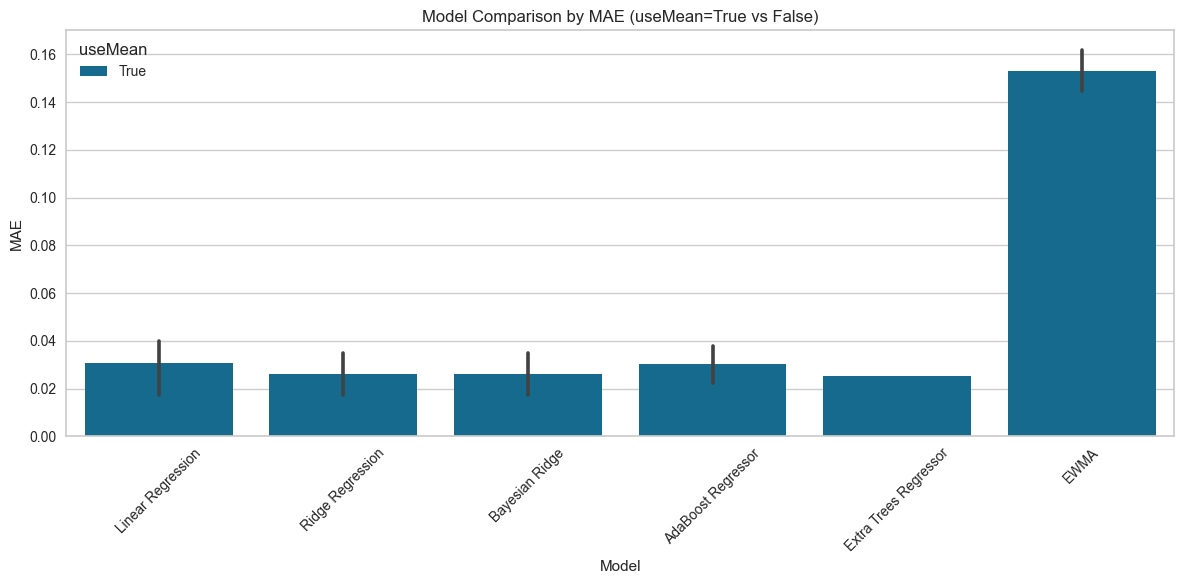

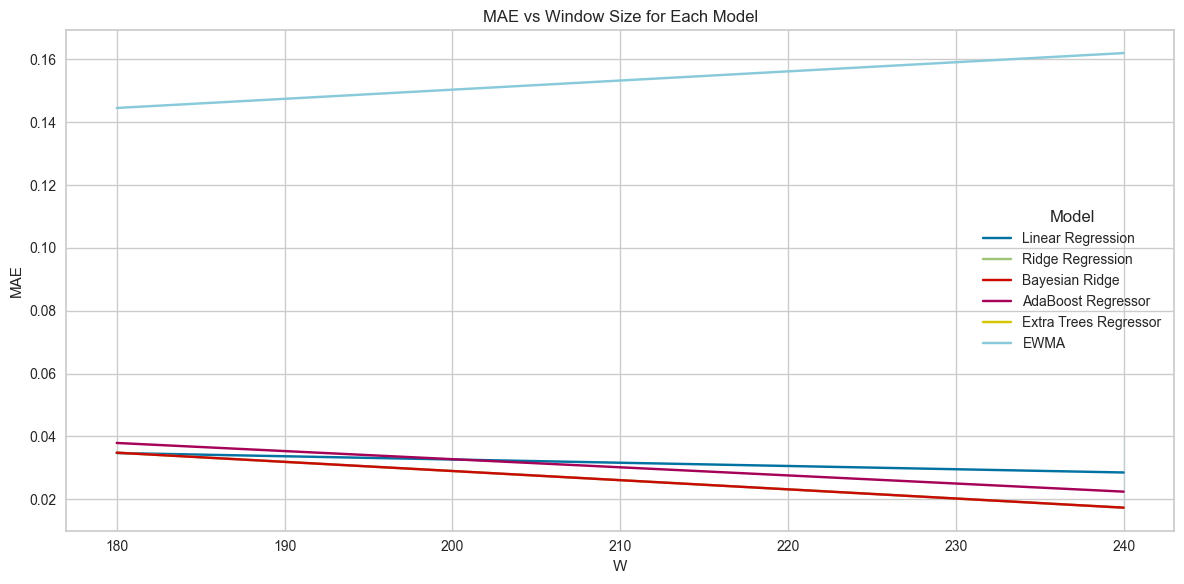

In [14]:
final_results = pd.concat(all_results, ignore_index=True)
top_models_df = (
    final_results
    .sort_values(by='MAE')
    .groupby('ticker', group_keys=False)
    .head(5)
)

ewma_best = (
    final_results[final_results['Model'] == 'EWMA']
    .sort_values(by='MAE')
    .groupby('ticker', group_keys=False)
    .head(1)
)

top_models_with_ewma_df = pd.concat([top_models_df, ewma_best], ignore_index=True)
top_models_with_ewma_df = top_models_with_ewma_df.sort_values(by='MAE')

# Display sorted table
display(top_models_with_ewma_df)

# Plot MAE across models
plt.figure(figsize=(12, 6))
sns.barplot(data=top_models_with_ewma_df, x='Model', y='MAE', hue='useMean')
plt.title('Model Comparison by MAE (useMean=True vs False)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_models_with_ewma_df, x='W', y='MAE', hue='Model', markers=True)
plt.title('MAE vs Window Size for Each Model')
plt.tight_layout()
plt.show()

__Hyperparameter Tuning__

In [15]:
def time_series_split(X, y, meta, train_size=0.6, val_size=0.2):
    """
    Split sequences into train/val/test by time (no shuffling).
    
    Args:
        X, y, meta : outputs from build_sequences
        train_size : fraction of data for training
        val_size   : fraction of data for validation (rest goes to test)
    
    Returns:
        (X_train, y_train, meta_train),
        (X_val, y_val, meta_val),
        (X_test, y_test, meta_test)
    """
    N = len(X)
    train_end = int(N * train_size)
    val_end   = int(N * (train_size + val_size))
    
    X_train, y_train, meta_train = X[:train_end], y[:train_end], meta.iloc[:train_end]
    X_val,   y_val,   meta_val   = X[train_end:val_end], y[train_end:val_end], meta.iloc[train_end:val_end]
    X_test,  y_test,  meta_test  = X[val_end:], y[val_end:], meta.iloc[val_end:]
    
    return (X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test)

In [16]:
def model_builder(hp_or_dict, H=3, input_shape=None):
    
    # If it's a dict, just read values directly
    if isinstance(hp_or_dict, dict):
        units   = hp_or_dict['units']
        depth   = hp_or_dict['depth']
        dropout = hp_or_dict['dropout']
        cell    = hp_or_dict['cell']
        lr      = hp_or_dict.get('lr', 0.001)
    else:
        # Otherwise assume it's a KerasTuner HyperParameters object
        units   = hp_or_dict.Int('units', min_value=32, max_value=128, step=32)
        depth   = hp_or_dict.Int('depth', 1, 3)
        dropout = hp_or_dict.Float('dropout', 0.1, 0.5, step=0.1)
        cell    = hp_or_dict.Choice('cell', ['LSTM', 'GRU'])
        lr      = hp_or_dict.Float('lr', 1e-4, 1e-2, sampling='log')
        
    model = models.Sequential()
    for i in range(depth):
        return_seq = (i < depth - 1)
        if i == 0:
            model.add(layers.BatchNormalization())
        if cell == 'LSTM':
            model.add(layers.LSTM(units, return_sequences=return_seq,
                                  input_shape=input_shape if i == 0 else None))
        else:
            model.add(layers.GRU(units, return_sequences=return_seq,
                                 input_shape=input_shape if i == 0 else None))
        model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(H))  # multi‑step output
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [17]:
def seq2seq_builder(hp_or_dict, H=3, input_shape=None):
    # Handle dict vs HyperParameters
    if isinstance(hp_or_dict, dict):
        units   = hp_or_dict['units']
        dropout = hp_or_dict['dropout']
        cell    = hp_or_dict['cell']
    else:
        units   = hp_or_dict.Int('units', min_value=32, max_value=128, step=32)
        dropout = hp_or_dict.Float('dropout', 0.1, 0.5, step=0.1)
        cell    = hp_or_dict.Choice('cell', ['LSTM', 'GRU'])

    # Encoder: produce context vector
    encoder_inputs = tf.keras.Input(shape=input_shape, name="encoder_inputs")
    if cell == 'LSTM':
        context = tf.keras.layers.LSTM(units, dropout=dropout, name="encoder_lstm")(encoder_inputs)
    else:
        context = tf.keras.layers.GRU(units, dropout=dropout, name="encoder_gru")(encoder_inputs)

    # Repeat context H times to form decoder input sequence
    repeated = tf.keras.layers.RepeatVector(int(H), name="repeat_vector")(context)

    # Decoder: generate H-step sequence
    if cell == 'LSTM':
        decoder_seq = tf.keras.layers.LSTM(units, return_sequences=True, dropout=dropout, name="decoder_lstm")(repeated)
    else:
        decoder_seq = tf.keras.layers.GRU(units, return_sequences=True, dropout=dropout, name="decoder_gru")(repeated)

    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1), name="decoder_dense")(decoder_seq)

    model = tf.keras.Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
deep_results = []

for name, df in dfs.items():
    for tbills in tbills_flags:
        for regime in regime_flags:
            for W in W_list:
                print(f"\nRunning {name} | W={W}, H={H}, tbills={tbills}, regime={regime}")

                # Step 1: Feature extraction
                XH, yH, metaH = feature_extraction(df, tbills=tbills, regime=regime, W=W, H=H)

                # Step 2: Time series split
                (X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = time_series_split(XH, yH, metaH)

                input_shape = X_train.shape[1:]  # (W, F)

                # Step 3: LSTM/GRU tuner
                tuner = kt.RandomSearch(
                    lambda hp: model_builder(hp, H=H, input_shape=input_shape),
                    objective='val_loss',
                    max_trials=10,
                    directory='tuner_dir',
                    project_name=f'deep_W{W}_H{H}_{name}_{tbills}_{regime}',
                    overwrite=True
                )

                tuner.search(X_train, y_train,
                             validation_data=(X_val, y_val),
                             epochs=30,
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

                best_hp = tuner.get_best_hyperparameters(1)[0]
                best_trial = tuner.oracle.get_best_trials(1)[0]
                best_val_loss = best_trial.metrics.get_last_value("val_loss")

                deep_results.append({
                    "Model": best_hp.get('cell'),
                    "W": W,
                    "H": H,
                    "tbills": tbills,
                    "regime": regime,
                    "ticker": name,
                    "val_loss": best_val_loss,
                    "best_hp": best_hp.values
                })

                # Step 4: Seq2Seq tuner
                tuner_seq = kt.RandomSearch(
                    lambda hp: seq2seq_builder(hp, H=H, input_shape=input_shape),
                    objective='val_loss',
                    max_trials=10,
                    directory='tuner_dir',
                    project_name=f'seq2seq_W{W}_H{H}_{name}_{tbills}_{regime}',
                    overwrite=True
                )

                tuner_seq.search(X_train, y_train,
                                 validation_data=(X_val, y_val),
                                 epochs=30,
                                 callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

                best_hp_seq = tuner_seq.get_best_hyperparameters(1)[0]
                best_trial_seq = tuner_seq.oracle.get_best_trials(1)[0]
                best_val_loss_seq = best_trial_seq.metrics.get_last_value("val_loss")

                deep_results.append({
                    "Model": "Seq2Seq_" + best_hp_seq.get('cell'),
                    "W": W,
                    "H": H,
                    "tbills": tbills,
                    "regime": regime,
                    "ticker": name,
                    "val_loss": best_val_loss_seq,
                    "best_hp": best_hp_seq.values
                })


Trial 1 Complete [00h 00m 10s]
val_loss: 0.310984343290329

Best val_loss So Far: 0.310984343290329
Total elapsed time: 00h 00m 10s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
32                |96                |units
0.5               |0.5               |dropout
GRU               |LSTM              |cell

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 1.2092 - val_loss: 1.2907
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 1.1657 - val_loss: 1.1912
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 1.2132 - val_loss: 1.1059
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 1.0215 - val_loss: 1.0220
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.9306 - val_loss: 0.9484
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.7176 - val_loss: 0.8852
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.5946 - val_loss: 0.8327
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.5824 - va

In [ ]:
deep_df = pd.DataFrame(deep_results)

# Sort and display
display(deep_df.sort_values('val_loss'))

# Plot performance
plt.figure(figsize=(12, 6))
sns.barplot(data=deep_df, x='Model', y='val_loss', hue='ticker')
plt.title('Deep Model Comparison by Validation Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


g = sns.FacetGrid(deep_df, col='ticker', height=4, aspect=1.2)
g.map_dataframe(sns.lineplot, x='W', y='val_loss', hue='Model', markers=True, dashes=False)
g.add_legend()
g.set_titles("{col_name}")
plt.suptitle('Validation Loss vs Window Size by Ticker', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
def predict_with_best_deep_model(model_name, best_hp, ticker, W, H, tbills, regime, epochs=30):
    """
    Retrains and predicts using the best deep model configuration.

    Parameters:
    - model_name: 'LSTM', 'GRU', 'Seq2Seq_LSTM', etc.
    - best_hp: dictionary of hyperparameters
    - ticker: e.g. 'SPY', 'QQQ'
    - W, H: window size and forecast horizon
    - tbills, regime: feature flags
    - epochs: number of training epochs

    Returns:
    - predictions: np.array from model.predict(X_test)
    - meta_test: metadata for test set (e.g. dates)
    """
    # Step 1: Filter ticker
    df_ticker = dfs[ticker]

    # Step 2: Feature extraction
    XH, yH, metaH = feature_extraction(df_ticker, tbills=tbills, regime=regime, W=W, H=H)

    # Step 3: Time series split
    (X_train, y_train, _), (_, _, _), (X_test, y_test, meta_test) = time_series_split(XH, yH, metaH)

    # Step 4: Build model
    input_shape = X_train.shape[1:]
    if model_name.startswith("Seq2Seq_"):
        cell = model_name.split("_")[1]
        best_hp['cell'] = cell
        model = seq2seq_builder(best_hp, H=H, input_shape=input_shape)
    else:
        best_hp['cell'] = model_name
        model = model_builder(best_hp, H=H, input_shape=input_shape)

    # Step 5: Compile and train
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)  
    
    # Save model to disk
    model_path = f"models/{ticker}_{model_name}_W{W}_H{H}.h5"  # NEW: file path
    model.save(model_path)  

    # Step 6: Predict
    predictions = model.predict(X_test)
    predictions = predictions.reshape(y_test.shape)   
    mae = mean_absolute_error(y_test, predictions)
    mae_1step = mean_absolute_error(y_test[:, 0], predictions[:, 0])
    rmse = mean_squared_error(y_test, predictions, squared=False)

    return predictions, meta_test, mae, mae_1step, y_test, history, rmse

In [ ]:
# Get best models per ticker
best_models_df = deep_df.sort_values('val_loss').groupby('ticker').head(1)

deep_mae_results = []

# Run predictions
results = {}
deep_mae_results = []

for _, row in best_models_df.iterrows():
    preds, meta, mae, mae_1step, y_test, history, rmse = predict_with_best_deep_model(
        model_name=row['Model'],
        best_hp=row['best_hp'],
        ticker=row['ticker'],
        W=row['W'],
        H=row['H'],
        tbills=row['tbills'],
        regime=row['regime'],
    )
    results[row['ticker']] = {
        'predictions': preds,
        'meta': meta,
        'y_test': y_test,
        'history': history,  
        'rmse': rmse         
    }

    deep_mae_results.append({
        'Model': row['Model'],
        'ticker': row['ticker'],
        'MAE': mae_1step,
        'RMSE': rmse         
    })


# Create the DataFrame
deep_mae_df = pd.DataFrame(deep_mae_results)

In [ ]:
for ticker in results:
    history = results[ticker]['history']
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{ticker} Training Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
best_mae_df = (
    top_models_with_ewma_df
    .sort_values(by='MAE')
    .groupby('ticker', group_keys=False)
    .head(1)
    [['Model', 'ticker', 'MAE']]
    .copy()
)
best_mae_df['Model'] = 'Traditional (' + best_mae_df['Model'] + ')'

combined_df = pd.concat([deep_mae_df, best_mae_df], ignore_index=True)

sns.barplot(data=combined_df, x='ticker', y='MAE', hue='Model')
plt.title('MAE Comparison: Deep vs Traditional Models')
plt.tight_layout()
plt.show()

In [ ]:
for ticker in results:
    preds = results[ticker]['predictions']  # shape: (n_samples, H)
    meta = results[ticker]['meta']          # metadata, optional for labeling
    H = preds.shape[1]
    y_test = results[ticker]['y_test']

    # Plot One Sample (last one)
    plt.figure(figsize=(10, 5))
    plt.plot(range(H), y_test[-1], label='Actual')
    plt.plot(range(H), preds[-1], label='Forecast')
    plt.title(f"{ticker} Forecast vs Actual (Last Sample)")
    plt.xlabel("Days Ahead")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Overlay All Samples
    plt.figure(figsize=(12, 6))
    for i in range(len(preds)):
        plt.plot(range(H), y_test[i], color='blue', alpha=0.3)
        plt.plot(range(H), preds[i], color='orange', alpha=0.3)
    plt.title(f"{ticker} Forecast vs Actual (All Samples Overlay)")
    plt.xlabel("Days Ahead")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Mean Forecast vs Mean Actual
    plt.figure(figsize=(10, 5))
    plt.plot(range(H), y_test.mean(axis=0), label='Actual Mean')
    plt.plot(range(H), preds.mean(axis=0), label='Forecast Mean')
    plt.title(f"{ticker} Mean Forecast vs Actual")
    plt.xlabel("Days Ahead")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()